<a href="https://colab.research.google.com/github/MaureenOShea/WiDS25_data-sleuthing/blob/main/wids_usaid_africa_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Sleuthing the Headlines
# What Data tells us about U.S. Foreign Aid (USAID) and Africa

In this notebook, we take on the role of a data detective, exploring the relationship between U.S. foreign aid (USAID) and GDP in African countries. With Python as our toolkit, we’ll go beyond the headlines to uncover meaningful patterns in how aid is distributed—and how it might connect to economic indicators across the continent.

We’ll investigate:

* How **USAID funding trends** have evolved over time

* Which **African countries receive the most aid**, and by **USAID category**

* The **relationship between aid and GDP**, including data distribution and correlation

Insights into how aid might align—or diverge—from economic development

Using pandas, seaborn, and other data science tools in a Google Colab environment, we’ll clean and analyze real-world datasets from **ForeignAssistance.gov** and the **World Bank**, critically exploring both numbers and narratives.

Let’s dig in and uncover the story the data tells about aid and growth in Africa.

---

Data Reference:

**World Bank** (Accessed March 2025)
World Development Indicators

* GDP (current US$) - [NY.GDP.MKTP.CD](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD)
* Population, total - [SP.POP.TOTL](https://data.worldbank.org/indicator/SP.POP.TOTL)

**ForeignAssistance.gov** (Accessed March 2025)  
https://foreignassistance.gov/data

*Stewards: U.S. Agency for International Development (USAID) and U.S. Department
of State on behalf of United States Government agencies reporting foreign assistance.*

# Set up

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Display tables
from IPython.display import display

# Display plots inline
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


## Read Data

In [16]:
path = "https://raw.githubusercontent.com/MaureenOShea/WiDS25_data-sleuthing/refs/heads/main/"

filename = "usaid_africa_foreignassistance_data.csv"
usaid = pd.read_csv(path + filename)

filename = 'gdp_africa_worldbank_data.csv'
wb = pd.read_csv(path + filename)

In [17]:
# Display basic info
display(usaid.info())
display(wb.info())
display(wb.head())
display(usaid.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422305 entries, 0 to 422304
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Country Code          422305 non-null  object
 1   Country Name          422305 non-null  object
 2   Income Group Acronym  422305 non-null  object
 3   US Category Name      422305 non-null  object
 4   Year                  422305 non-null  int64 
 5   Amount USD            422305 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 19.3+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  530 non-null    object 
 1   Year          530 non-null    int64  
 2   GDP USD       530 non-null    float64
 3   Population    530 non-null    int64  
 4   Country Code  530 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 20.8+ KB


None

,Country Name,Year,GDP USD,Population,Country Code
0,Algeria,2014,2.389427e+11,39205031,DZA
1,Algeria,2015,1.874939e+11,40019529,DZA
2,Algeria,2016,1.807638e+11,40850721,DZA
3,Algeria,2017,1.898809e+11,41689299,DZA
4,Algeria,2018,1.945545e+11,42505035,DZA


,Country Code,Country Name,Income Group Acronym,US Category Name,Year,Amount USD
0,DZA,Algeria,UMIC,Humanitarian Assistance,2015,137383
1,DZA,Algeria,UMIC,Humanitarian Assistance,2015,118499
2,DZA,Algeria,UMIC,Humanitarian Assistance,2016,361967
3,DZA,Algeria,UMIC,Humanitarian Assistance,2016,703308
4,DZA,Algeria,UMIC,Humanitarian Assistance,2016,568517


## Preprocessing

## Merge USAID and World Bank data: merged_df

In [18]:
# Merge USAID data with World Bank population data
merged_df = pd.merge(usaid,wb[["Country Code", "Year", "Population", "GDP USD"]],on=["Country Code", "Year"],how="left")

# Drop records with missing population
merged_df = merged_df.dropna(subset=["Population","GDP USD"])

# Combine specified US Category Name categories
combined_categories = ['Democracy, Human Rights, and Governance', 'Education and Social Services', 'Peace and Security', 'Environment']
merged_df['US Category Name'] = merged_df['US Category Name'].apply(lambda x: 'Combined Categories' if x in combined_categories else x)

display(merged_df.info(), merged_df.describe())

# get unique values for categorical columns

for column in merged_df.columns:
  if merged_df[column].dtype == 'object':
    display(f"Unique values for {column}: {merged_df[column].unique()}")



<class 'pandas.core.frame.DataFrame'>
Index: 422287 entries, 0 to 422304
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Country Code          422287 non-null  object 
 1   Country Name          422287 non-null  object 
 2   Income Group Acronym  422287 non-null  object 
 3   US Category Name      422287 non-null  object 
 4   Year                  422287 non-null  int64  
 5   Amount USD            422287 non-null  int64  
 6   Population            422287 non-null  float64
 7   GDP USD               422287 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 29.0+ MB


None

,Year,Amount USD,Population,GDP USD
count,422287.000000,4.222870e+05,4.222870e+05,4.222870e+05
mean,2018.657257,1.959828e+05,4.752133e+07,8.059702e+10
std,2.882257,1.485406e+06,5.073665e+07,1.244189e+11
min,2014.000000,-2.425412e+07,9.135900e+04,2.599996e+08
25%,2016.000000,1.772500e+03,1.547500e+07,1.317631e+10
50%,2019.000000,1.553800e+04,2.869607e+07,3.233808e+10
75%,2021.000000,1.137700e+05,5.565289e+07,7.426336e+10
max,2023.000000,1.869283e+08,2.278829e+08,5.741838e+11


"Unique values for Country Code: ['DZA' 'AGO' 'BWA' 'BDI' 'CMR' 'CPV' 'CAF' 'TCD' 'COM' 'COG' 'COD' 'BEN'\n 'GNQ' 'ETH' 'DJI' 'GAB' 'GMB' 'GHA' 'GIN' 'CIV' 'KEN' 'LSO' 'LBR' 'LBY'\n 'MDG' 'MWI' 'MLI' 'MRT' 'MUS' 'MAR' 'MOZ' 'NAM' 'NER' 'NGA' 'GNB' 'RWA'\n 'STP' 'SEN' 'SYC' 'SLE' 'SOM' 'ZAF' 'ZWE' 'SSD' 'SDN' 'SWZ' 'TGO' 'TUN'\n 'UGA' 'EGY' 'TZA' 'BFA' 'ZMB']"

'Unique values for Country Name: [\'Algeria\' \'Angola\' \'Botswana\' \'Burundi\' \'Cameroon\' \'Cabo Verde\'\n \'Central African Republic\' \'Chad\' \'Comoros\' \'Congo (Brazzaville)\'\n \'Congo (Kinshasa)\' \'Benin\' \'Equatorial Guinea\' \'Ethiopia\' \'Djibouti\'\n \'Gabon\' \'Gambia\' \'Ghana\' \'Guinea\' "Cote d\'Ivoire" \'Kenya\' \'Lesotho\'\n \'Liberia\' \'Libya\' \'Madagascar\' \'Malawi\' \'Mali\' \'Mauritania\' \'Mauritius\'\n \'Morocco\' \'Mozambique\' \'Namibia\' \'Niger\' \'Nigeria\' \'Guinea-Bissau\'\n \'Rwanda\' \'Sao Tome and Principe\' \'Senegal\' \'Seychelles\' \'Sierra Leone\'\n \'Somalia\' \'South Africa\' \'Zimbabwe\' \'South Sudan\' \'Sudan\' \'Eswatini\'\n \'Togo\' \'Tunisia\' \'Uganda\' \'Egypt\' \'Tanzania\' \'Burkina Faso\' \'Zambia\']'

"Unique values for Income Group Acronym: ['UMIC' 'LMIC' 'LIC' 'HIC']"

"Unique values for US Category Name: ['Humanitarian Assistance' 'Health' 'Program Support'\n 'Combined Categories' 'Economic Development']"

In [19]:
merged_df.head()

,Country Code,Country Name,Income Group Acronym,US Category Name,Year,Amount USD,Population,GDP USD
0,DZA,Algeria,UMIC,Humanitarian Assistance,2015,137383,40019529.0,1.874939e+11
1,DZA,Algeria,UMIC,Humanitarian Assistance,2015,118499,40019529.0,1.874939e+11
2,DZA,Algeria,UMIC,Humanitarian Assistance,2016,361967,40850721.0,1.807638e+11
3,DZA,Algeria,UMIC,Humanitarian Assistance,2016,703308,40850721.0,1.807638e+11
4,DZA,Algeria,UMIC,Humanitarian Assistance,2016,568517,40850721.0,1.807638e+11


# EDA



## Trends over Time
1. Aggregate overall USAID funding and USAID funding by category and income group.

2. Visualize trends over time and ask the following questions:


*   Are USAID funding levels rising or falling over time across Africa?
*   Do funding spikes align with GDP downturns (e.g., during crises)?



### Total USAID to AFRICA over Time

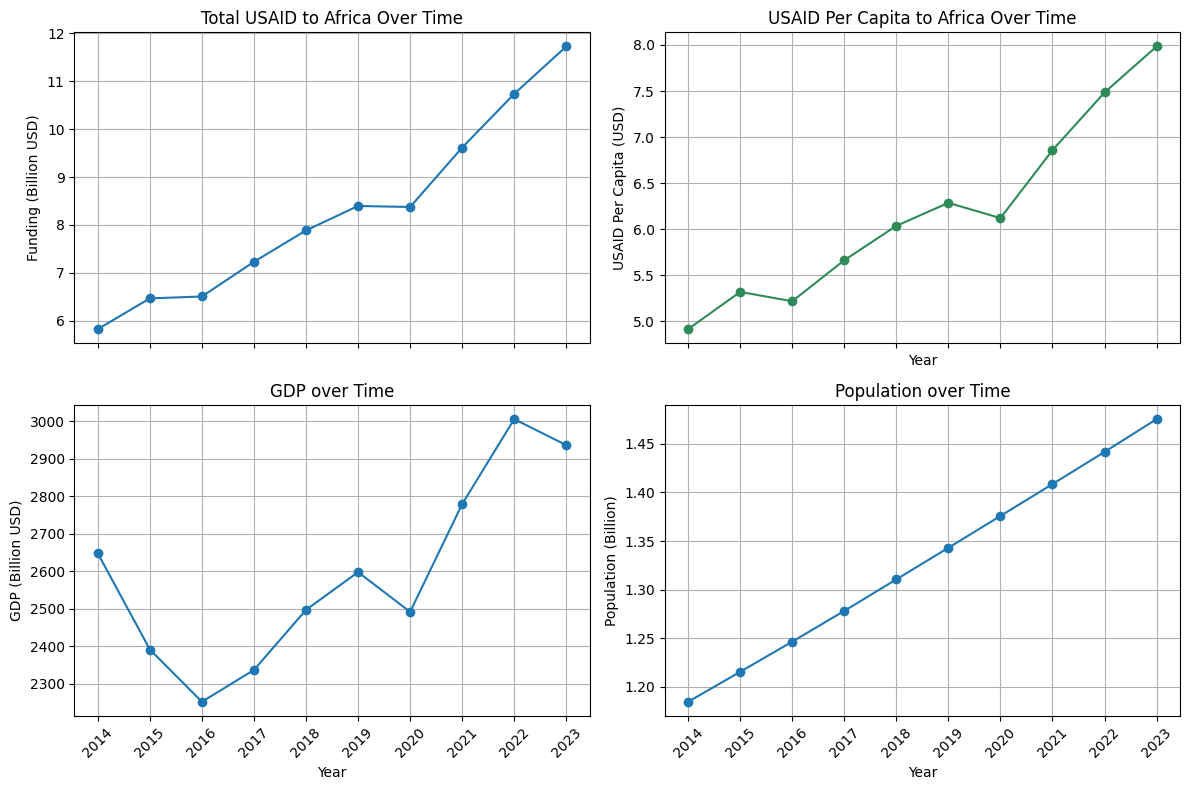

In [20]:
# --- Total USAID and Per Capita USAID Funding by Year ---

# Step 1: Aggregate funding at the country-year level
country_year_funding = merged_df.groupby(["Country Code", "Year", "Population"])["Amount USD"].sum().reset_index()

# Step 2: Aggregate to year level for total funding and population
per_capita_africa_by_year = (country_year_funding.groupby("Year")[["Amount USD", "Population"]].sum().reset_index())

# Total USAID Funding (in billions)
per_capita_africa_by_year["Amount (Billion USD)"] = per_capita_africa_by_year["Amount USD"] / 1e9

# Step 3: Compute per capita funding
per_capita_africa_by_year["Amount Per Capita USD"] = (per_capita_africa_by_year["Amount USD"] / per_capita_africa_by_year["Population"])

# --- Total GDP for each year in Billions ---
gdp_by_year = wb.groupby('Year')['GDP USD'].sum() /1e9

# --- Total Population for each year in Billions  ---
population_by_year = wb.groupby('Year')['Population'].sum() / 1e9


# Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Plot 1: Total USAID Funding (in billions)
axes[0, 0].plot(per_capita_africa_by_year["Year"], per_capita_africa_by_year["Amount (Billion USD)"], marker='o',)
axes[0, 0].set_title("Total USAID to Africa Over Time")
axes[0, 0].set_ylabel("Funding (Billion USD)")
axes[0, 0].grid(True)

# Plot 2: USAID Per Capita Funding
axes[0, 1].plot(per_capita_africa_by_year["Year"], per_capita_africa_by_year["Amount Per Capita USD"], marker='o', color='seagreen')
axes[0, 1].set_title("USAID Per Capita to Africa Over Time")
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("USAID Per Capita (USD)")
axes[0, 1].grid(True)

# Plot 3: GDP
axes[1, 0].plot(gdp_by_year.index, gdp_by_year.values, marker='o',)
axes[1, 0].set_title('GDP over Time')
axes[1, 0].set_ylabel('GDP (Billion USD)')
axes[1, 0].set_xlabel("Year")
axes[1, 0].grid(True)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_xticks(gdp_by_year.index) # Set xticks to all years

# Plot 4: Population
axes[1, 1].plot(population_by_year.index, population_by_year.values, marker='o')
axes[1, 1].set_title('Population over Time')
axes[1, 1].set_ylabel('Population (Billion)')
axes[1, 1].set_xlabel("Year")
axes[1, 1].grid(True)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_xticks(population_by_year.index) # Set xticks to all years

# Final layout
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### USAID to AFRICA by Category and Income Group over Time

### US Categories
1. Humanitarian Assistance
2. Health
3. Program Support
4. Economic Development
5. Combined Categories:
> Democracy, Human Rights, and Governance  
> Education and Social Services  
> Peace and Security  
> Environment  

### Income Groups

The World Bank classifies countries into four income groups based on Gross National Income (GNI) per capita

Income Group Acronyms:
* **LIC (Low income economies)**: GNI per capita of \$1,145 or less in 2023.
* **LMIC (Lower-middle-income economies)**: GNI per capita between \$1,146 and \$4,515 in 2023.
* **UMIC (Upper-middle-income economies)**: GNI per capita between \$4,516 and \$14,005 in 2023.
* **HIC (High-income economies)**: GNI per capita of more than \$14,005 in 2023.

In [21]:
# Countries belonging to each Income Group

# Group by 'Income Group Acronym' and get unique countries within each group
income_group_countries = merged_df.groupby('Income Group Acronym')['Country Name'].unique()

# Print the results
for income_group, countries in income_group_countries.items():
  print(f"{income_group}: {countries}")
  print("`\n")

HIC: ['Seychelles']
`

LIC: ['Burundi' 'Central African Republic' 'Chad' 'Congo (Kinshasa)' 'Benin'
 'Ethiopia' 'Gambia' 'Guinea' 'Liberia' 'Madagascar' 'Malawi' 'Mali'
 'Mozambique' 'Niger' 'Guinea-Bissau' 'Rwanda' 'Sierra Leone' 'Somalia'
 'South Sudan' 'Togo' 'Uganda' 'Tanzania' 'Burkina Faso']
`

LMIC: ['Angola' 'Cameroon' 'Cabo Verde' 'Comoros' 'Congo (Brazzaville)'
 'Djibouti' 'Ghana' "Cote d'Ivoire" 'Kenya' 'Lesotho' 'Mauritania'
 'Morocco' 'Nigeria' 'Sao Tome and Principe' 'Senegal' 'Zimbabwe' 'Sudan'
 'Eswatini' 'Tunisia' 'Egypt' 'Zambia']
`

UMIC: ['Algeria' 'Botswana' 'Equatorial Guinea' 'Gabon' 'Libya' 'Mauritius'
 'Namibia' 'South Africa']
`



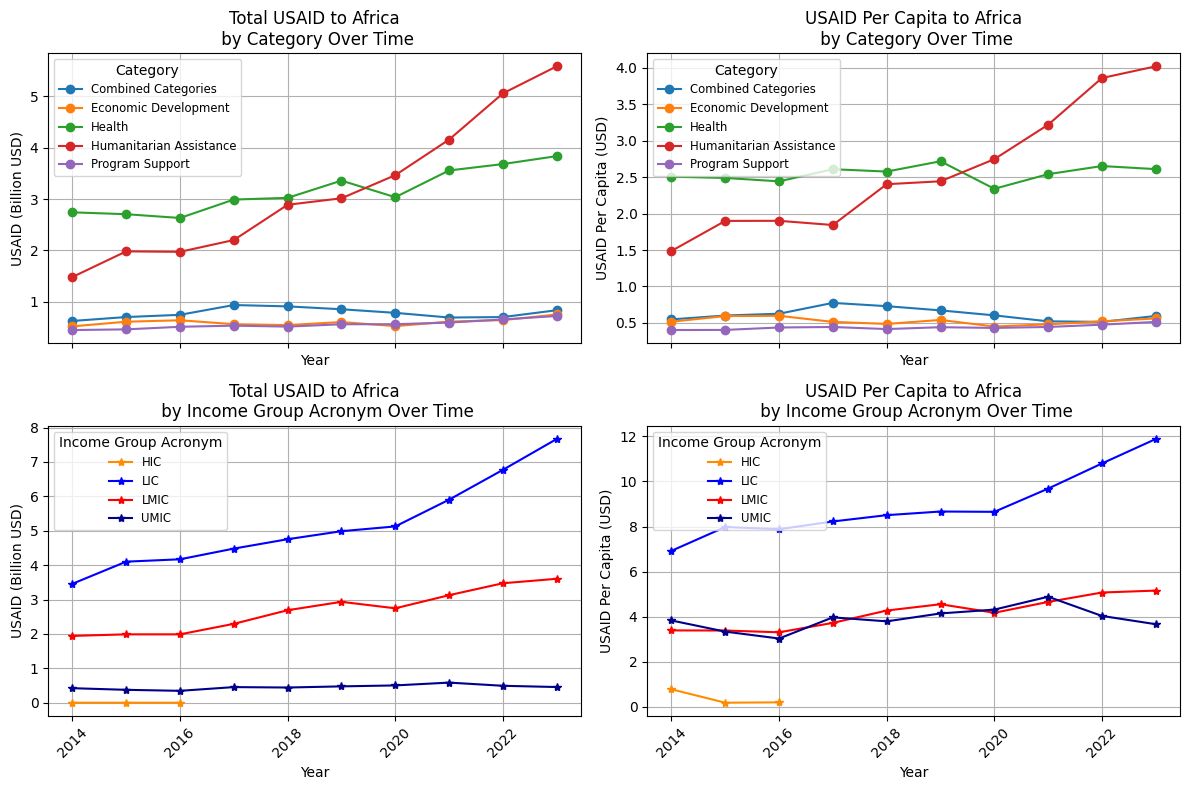

In [25]:
# --- USAID by Category by Year ---
funding_by_category = (merged_df.groupby(["Year", "US Category Name"])["Amount USD"].sum().reset_index())

funding_by_category["Amount (Billion USD)"] = funding_by_category["Amount USD"] / 1e9

pivot_total = funding_by_category.pivot(index="Year", columns="US Category Name", values="Amount (Billion USD)")

# --- Per Capita USAID by Category by Year ---

# Step 1: Aggregate funding at the country-year level
category_country_year_funding = merged_df.groupby(["Year", "US Category Name", "Country Code", "Population"])["Amount USD"].sum().reset_index()

# Step 2: Calculate US category level
per_capita_funding_by_category_year = category_country_year_funding.groupby(["Year", "US Category Name"])[["Amount USD", "Population"]].sum().reset_index()

# Step 3: Amount Per Capita (USD) by year
per_capita_funding_by_category_year["Amount Per Capita (USD)"] = per_capita_funding_by_category_year["Amount USD"] / per_capita_funding_by_category_year["Population"]
per_capita_funding_by_category_year

pivot_per_capita = per_capita_funding_by_category_year.pivot(index="Year", columns="US Category Name", values="Amount Per Capita (USD)")

# --- USAID by Income Group Acronym by Year ---
funding_by_ig = (merged_df.groupby(["Year", "Income Group Acronym"])["Amount USD"].sum().reset_index())

funding_by_ig["Amount (Billion USD)"] = funding_by_ig["Amount USD"] / 1e9

pivot_total_ig = funding_by_ig.pivot(index="Year", columns="Income Group Acronym", values="Amount (Billion USD)")

# --- Per Capita USAID Income Group Acronym by Year ---

# Step 1: Aggregate funding at the country-year level
category_country_year_funding = merged_df.groupby(["Year", "Income Group Acronym", "Country Code", "Population"])["Amount USD"].sum().reset_index()

# Step 2: Calculate US category level
per_capita_funding_by_ig_year = category_country_year_funding.groupby(["Year", "Income Group Acronym"])[["Amount USD", "Population"]].sum().reset_index()

# Step 3: Amount Per Capita (USD) by year
per_capita_funding_by_ig_year["Amount Per Capita (USD)"] = per_capita_funding_by_ig_year["Amount USD"] / per_capita_funding_by_ig_year["Population"]
per_capita_funding_by_ig_year

pivot_per_capita_ig = per_capita_funding_by_ig_year.pivot(index="Year", columns="Income Group Acronym", values="Amount Per Capita (USD)")
# Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Plot 1
for column in pivot_total.columns:
    axes[0, 0].plot(pivot_total.index, pivot_total[column], marker='o', label=column)
    axes[0, 0].set_title("Total USAID to Africa\n by Category Over Time")
    axes[0, 0].set_ylabel("USAID (Billion USD)")
    axes[0, 0].set_xlabel("Year")
    axes[0, 0].grid(True)
    axes[0, 0].legend(title="Category", loc="upper left", fontsize='small')
    axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2
for column in pivot_per_capita.columns:
    axes[0, 1].plot(pivot_per_capita.index, pivot_per_capita[column], marker='o', label=column)
    axes[0, 1].set_title("USAID Per Capita to Africa\n by Category Over Time")
    axes[0, 1].set_ylabel("USAID Per Capita (USD)")
    axes[0, 1].set_xlabel("Year")
    axes[0, 1].grid(True)
    axes[0, 1].legend(title="Category",loc="upper left", fontsize='small')
    axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3
colors = ['darkorange', 'blue','red', 'darkblue'] # Define a list of colors
for i, column in enumerate(pivot_total_ig.columns):
    axes[1, 0].plot(pivot_total_ig.index, pivot_total_ig[column], marker='*', label=column, color=colors[i % len(colors)])
    axes[1, 0].set_title("Total USAID to Africa\n by Income Group Acronym Over Time")
    axes[1, 0].set_ylabel("USAID (Billion USD)")
    axes[1, 0].set_xlabel("Year")
    axes[1, 0].grid(True)
    axes[1, 0].legend(title="Income Group Acronym", loc="upper left", fontsize='small')
    axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4
for i, column in enumerate(pivot_per_capita_ig.columns):
    axes[1, 1].plot(pivot_per_capita_ig.index, pivot_per_capita_ig[column], marker='*', label=column, color=colors[i % len(colors)])
    axes[1, 1].set_title("USAID Per Capita to Africa\n by Income Group Acronym Over Time")
    axes[1, 1].set_ylabel("USAID Per Capita (USD)")
    axes[1, 1].set_xlabel("Year")
    axes[1, 1].grid(True)
    axes[1, 1].legend(title="Income Group Acronym", loc="upper left", fontsize='small')
    axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Trends over Time Observations

####Total Funding:

*   USAID's Funding increases fairly linearly over time.
*  USAID's Funding spikes align with some GDP downturns.

####Category Breakdown:

*   Health and Humanitarian Assistance receives the largest portion of funding.
*   Humanitarian Assistance increases most rapidly.
*   Categories like Program Support, Economic Development and Other are relatively smaller but present.

####Income Group Breakdown:

* Countries in the lowest-income group receive the most funding.   
*   Low-income countries receive the most funding.
*   Lower-middle-income and upper-middle-income countries receive similar funding per capita.
*   Lower-middle-income countries receive higher total funding than Upper-middle-income.

### World Bank Indicator Trends
* Population increases linearly over the years.
* GDP fluctuates over the years.


---




## Who Received Aid in 2023?

### Heatmap: US Category by Country for 2023

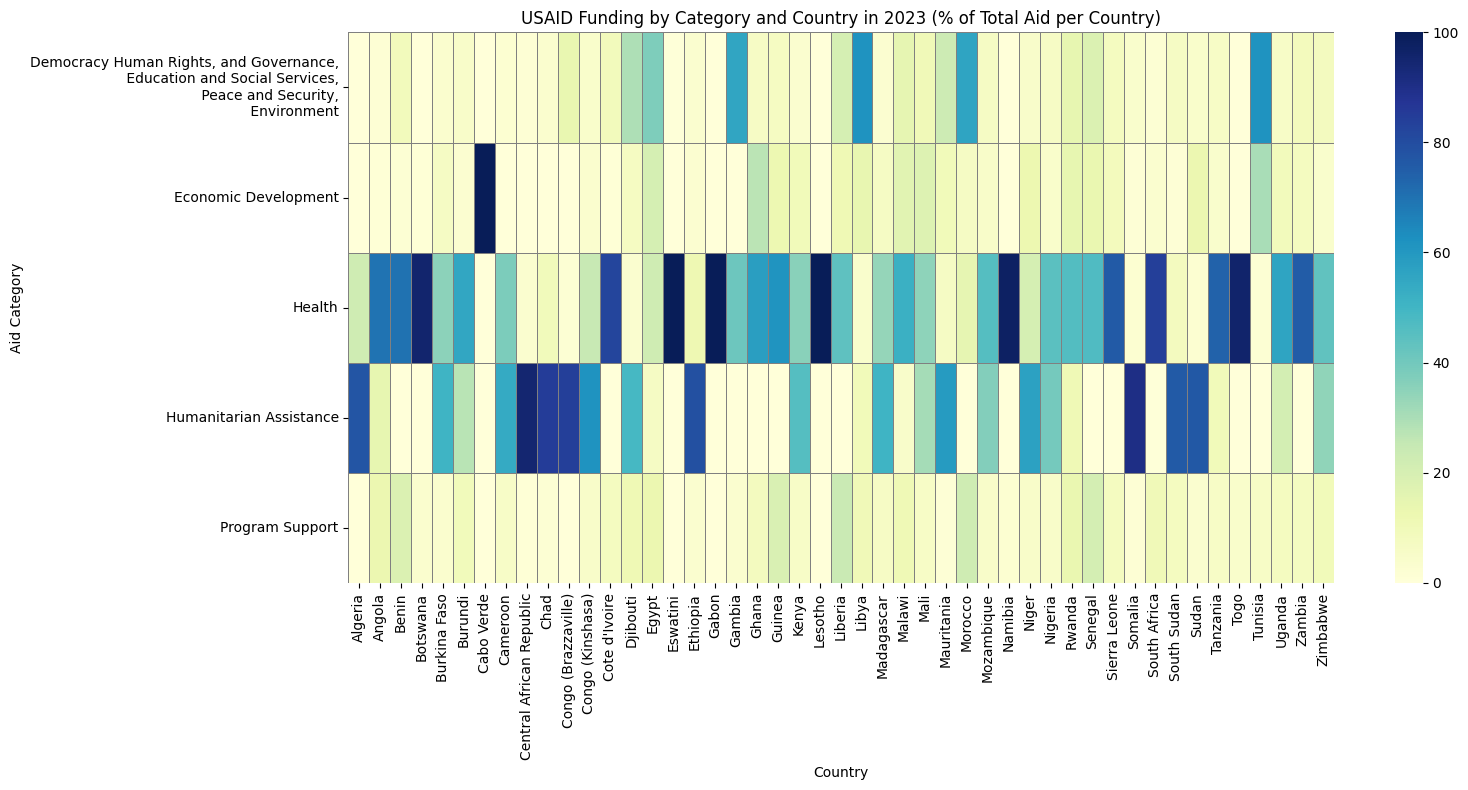

In [26]:
# Replace "Combined Categories" with the specified new label in 2023 data
merged_df["US Category Name"] = merged_df["US Category Name"].replace({
    "Combined Categories": "Democracy Human Rights, and Governance,\n Education and Social Services,\n Peace and Security,\n Environment"})

# Recreate the 2023 percentage heatmap with updated category name
merged_df_2023 = merged_df[merged_df["Year"] == 2023]
heatmap_data_2023 = (merged_df_2023.groupby(["Country Name", "US Category Name"])["Amount USD"].sum().reset_index())

heatmap_matrix_2023 = heatmap_data_2023.pivot(index="Country Name", columns="US Category Name", values="Amount USD").fillna(0)
country_totals = heatmap_matrix_2023.sum(axis=1)
heatmap_pct_2023 = heatmap_matrix_2023.div(country_totals, axis=0) * 100
heatmap_pct_2023_T = heatmap_pct_2023.T

# Plot the updated heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_pct_2023_T, cmap="YlGnBu", linewidths=0.5, linecolor='gray', annot=False)
plt.title("USAID Funding by Category and Country in 2023 (% of Total Aid per Country)")
plt.xlabel("Country")
plt.ylabel("Aid Category")
plt.tight_layout()
plt.show()


###Countries Recieving most USAID in 2023

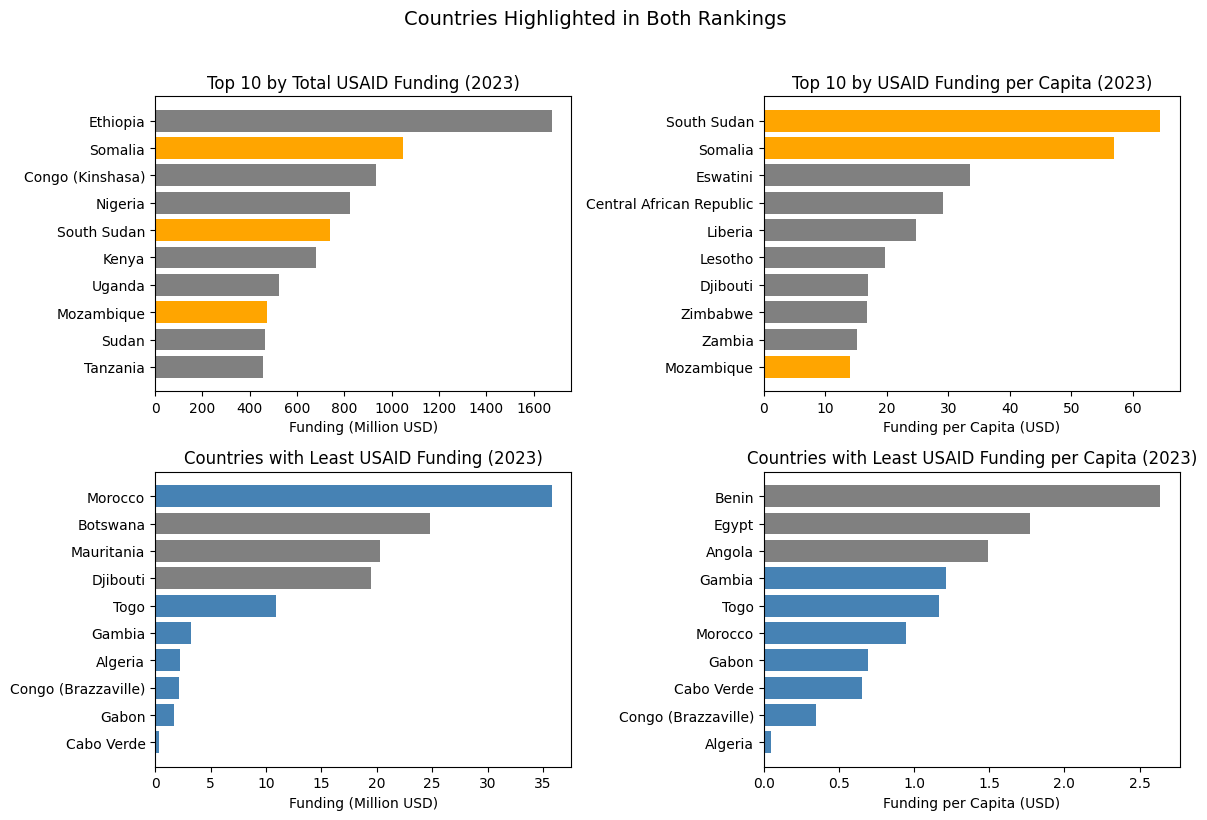

In [27]:
# Countries receiving the most USAID in 2023

# --- Filter and prepare 2023 data ---
usaid_2023 = merged_df[merged_df["Year"] == 2023]

# --- Aggregate total funding and population by country ---
country_funding_2023 =(usaid_2023.groupby("Country Name").agg({"Amount USD": "sum", "Population": "mean"}).reset_index())

# Calculate per capita funding
country_funding_2023["Funding per Capita"] = (country_funding_2023["Amount USD"] / country_funding_2023["Population"])

# --- Top 10 lists ---
top_total_2023 = country_funding_2023.nlargest(10, "Amount USD")
top_total_2023 = top_total_2023.sort_values(by="Amount USD", ascending=True).head(10)
top_per_capita_2023 = country_funding_2023.nlargest(10, "Funding per Capita")
top_per_capita_2023 = top_per_capita_2023.sort_values(by="Funding per Capita", ascending=True).head(10)

# Identify overlapping countries
shared_countries = set(top_total_2023["Country Name"]) & set(top_per_capita_2023["Country Name"])

# Countries receiving the least USAID in 2023

# --- Top 10 lists ---
bottom_total_2023 = country_funding_2023.nsmallest(10, "Amount USD")
bottom_per_capita_2023 = country_funding_2023.nsmallest(10, "Funding per Capita")

# Identify overlapping countries
bottom_shared_countries = set(bottom_total_2023["Country Name"]) & set(bottom_per_capita_2023["Country Name"])



# ---Plots---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)

# Left: Total funding
for _, row in top_total_2023.iterrows():
    color = "orange" if row["Country Name"] in shared_countries else "gray"
    axes[0, 0].barh(row["Country Name"], row["Amount USD"] / 1e6, color=color)
    axes[0, 0].set_title("Top 10 by Total USAID Funding (2023)")
    axes[0, 0].set_xlabel("Funding (Million USD)")
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x')

# Right: Per capita funding
for _, row in top_per_capita_2023.iterrows():
    color = "orange" if row["Country Name"] in shared_countries else "gray"
    axes[0, 1].barh(row["Country Name"], row["Funding per Capita"], color=color)
    axes[0, 1].set_title("Top 10 by USAID Funding per Capita (2023)")
    axes[0, 1].set_xlabel("Funding per Capita (USD)")
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(axis='x')

# Left: Total funding
for _, row in bottom_total_2023.iterrows():
    color = "steelblue" if row["Country Name"] in bottom_shared_countries else "gray"
    axes[1, 0].barh(row["Country Name"], row["Amount USD"] / 1e6, color=color)
    axes[1, 0].set_title("Countries with Least USAID Funding (2023)")
    axes[1, 0].set_xlabel("Funding (Million USD)")
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(axis='x')

# Right: Per capita funding
for _, row in bottom_per_capita_2023.iterrows():
    color = "steelblue" if row["Country Name"] in bottom_shared_countries else "gray"
    axes[1, 1].barh(row["Country Name"], row["Funding per Capita"], color=color)
    axes[1, 1].set_title("Countries with Least USAID Funding per Capita (2023)")
    axes[1, 1].set_xlabel("Funding per Capita (USD)")
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(axis='x')

plt.suptitle("Countries Highlighted in Both Rankings", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


##Correlation
* Is there correlation between USAID funding and GDP?
* How does funding relate to GDP per capita?


Explore the correlation between:

* USAID funding (Amount USD)

* GDP (GDP USD)

* Population

* GDP per capita

* USAID funding per capita (Amount per Capita)

### ScatterPlots

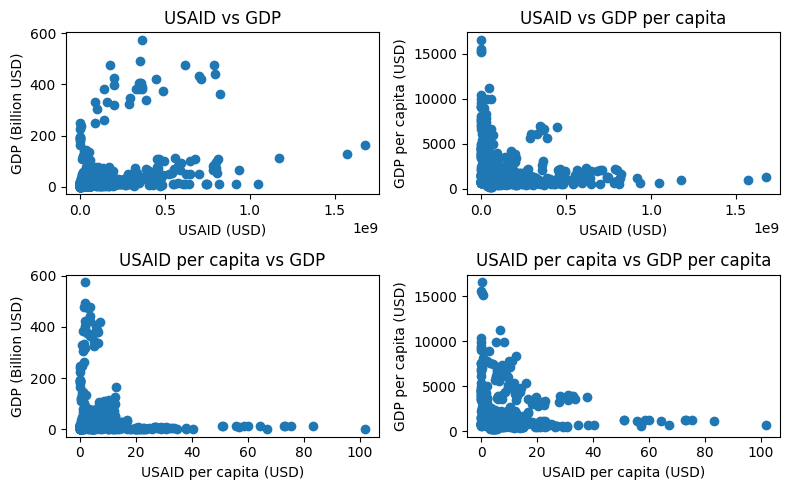

In [28]:
# Correlation Scatterplots

# Group the merged dataframe by 'Country Code', 'Country Name', and 'Year'
grouped_df = merged_df.groupby(['Country Code', 'Country Name', 'Year'], as_index=False).agg({
    'Amount USD': 'sum',      # Sum the assistance amounts for the same country-year
    'GDP USD': 'mean',       # Assuming GDP and Population are consistent within each country-year, take the mean entry
    'Population': 'mean'})


# Create new columns for per capita values
grouped_df['GDP per Capita'] = grouped_df['GDP USD'] / grouped_df['Population']
grouped_df['Amount per Capita'] = grouped_df['Amount USD'] / grouped_df['Population']

grouped_df['GDP (Billion USD)'] = grouped_df['GDP USD'] / 1e9

# Scatter plots
fig, axes = plt.subplots(2, 2, figsize=(8,5))

# Plot 1: USAID vs GDP
axes[0, 0].scatter(grouped_df['Amount USD'], grouped_df['GDP (Billion USD)'])
axes[0, 0].set_title('USAID vs GDP')
axes[0, 0].set_xlabel('USAID (USD)')
axes[0, 0].set_ylabel('GDP (Billion USD)')

# Plot 2: USAID vs GDP per capita
axes[0, 1].scatter(grouped_df['Amount USD'], grouped_df['GDP per Capita'])
axes[0, 1].set_title('USAID vs GDP per capita')
axes[0, 1].set_xlabel('USAID (USD)')
axes[0, 1].set_ylabel('GDP per capita (USD)')

# Plot 3: USAID per capita vs GDP
axes[1, 0].scatter(grouped_df['Amount per Capita'], grouped_df['GDP (Billion USD)'])
axes[1, 0].set_title('USAID per capita vs GDP')
axes[1, 0].set_xlabel('USAID per capita (USD)')
axes[1, 0].set_ylabel('GDP (Billion USD)')

# Plot 4: USAID per capita vs GDP per capita
axes[1, 1].scatter(grouped_df['Amount per Capita'], grouped_df['GDP per Capita'])
axes[1, 1].set_title('USAID per capita vs GDP per capita')
axes[1, 1].set_xlabel('USAID per capita (USD)')
axes[1, 1].set_ylabel('GDP per capita (USD)')

plt.tight_layout()
plt.show()

### Scatterplot Observation
* No visible signs of linear correlation. Try a non-linear transformation and inspect for outliers.

### Data Distribution

Numeric columns (excluding Year): ['Amount USD', 'GDP USD', 'Population', 'GDP per Capita', 'Amount per Capita', 'GDP (Billion USD)']


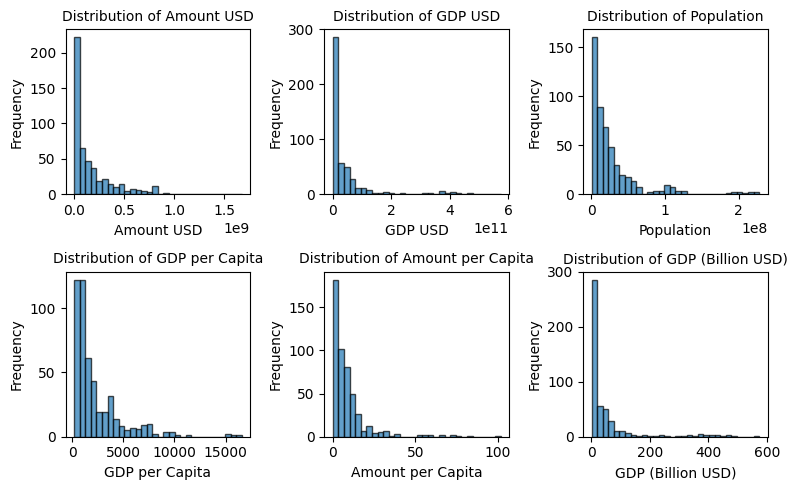

In [30]:
# Identify numeric columns excluding 'Year'
numeric_columns = [col for col in grouped_df.select_dtypes(include=[np.number]).columns if col != 'Year']
print("Numeric columns (excluding Year):", numeric_columns)

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(8, 5))
axes = axes.flatten()  # Flatten to iterate easily over all axes

# Plot histogram for each numeric column on a separate subplot
for i, col in enumerate(numeric_columns):
    axes[i].hist(grouped_df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {col}', fontsize=10)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


### Data Distribution Observation
* Skewed distributions. Try a non-linear transformation and inspect for outliers.
* Visualize with boxplots.

### Correlation Matrix

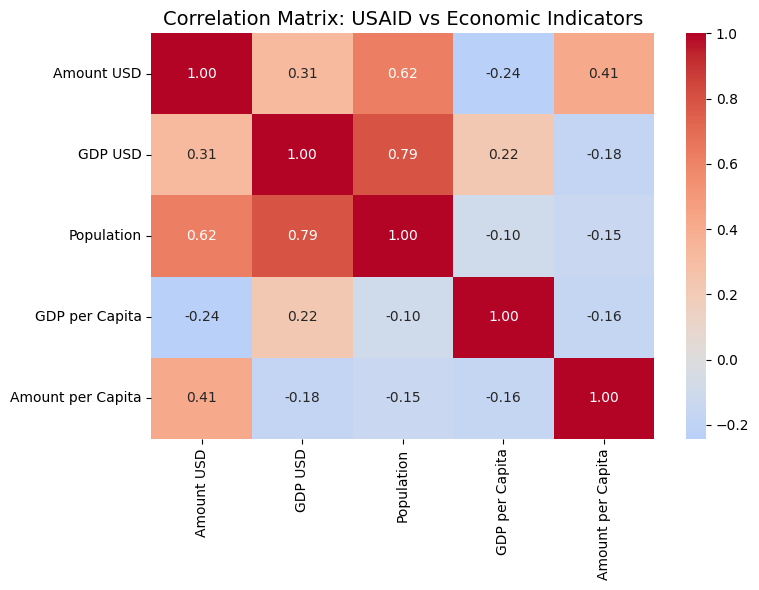

In [31]:
# Correlation Matrix
# Group the merged dataframe by 'Country Code', 'Country Name', and 'Year'
grouped_df = merged_df.groupby(['Country Code', 'Country Name', 'Year'], as_index=False).agg({
    'Amount USD': 'sum',      # Sum the assistance amounts for the same country-year
    'GDP USD': 'mean',       # Assuming GDP and Population are consistent within each country-year, take the mean entry
    'Population': 'mean'
})


# Create new columns for per capita values
grouped_df['GDP per Capita'] = grouped_df['GDP USD'] / grouped_df['Population']
grouped_df['Amount per Capita'] = grouped_df['Amount USD'] / grouped_df['Population']


# Select relevant columns for correlation analysis
correlation_data = grouped_df[["Amount USD", "GDP USD", "Population", "GDP per Capita", "Amount per Capita"]]

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")

# Add title
plt.title("Correlation Matrix: USAID vs Economic Indicators", fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### Correlation Observations

### Correlation Matrix
* USAID funding (Amount USD) is not strongly correlated with GDP (0.31) or GDP Per Capita (-0.24).
* USAID per Capita (Amount per Capita) is not correlated with GDP metrics.
* GDP USD is highly correlated with Population (0.79), which makes sense — bigger countries tend to have higher GDPs.
* USAID (Amount) is moderately correlated with Population (.62).

####There is little evidence of a direct linear correlation between USAID funding and GDP metrics.


# Next Steps
Looking to take your analysis further? Here are a few ideas to continue your data sleuthing journey:

* Drill Down by Income Level: Group countries by World Bank income classification

* Year-over-Year Change Analysis: Investigate which countries saw the largest increases or decreases in aid across different categories over time.

* Aid Effectiveness Metrics: Bring in external indicators (e.g., poverty rates, health outcomes, education metrics) to explore correlations between aid received and development outcomes.

* Clustering: group countries with similar aid profiles